## Prediction of house price using regression modelling

The house prices depend on various factors and such factors varies across different markets. In this analysis, we use the King County, USA data set to build a regression model that will help predict the house prices in that region given a set of attributes. I will try to identify a set of attributes and use a mixture of regression techniques to see which technique gives the best negative mean squared error.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('kc_house_data.csv')
data.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [6]:
print(data.shape)

(21613, 21)


Check for missing or null values in the data set. Looks like everything is in place. 

In [7]:
print(data.isnull().any())

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool


In [8]:
print(data.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


From the output above, some of the columns are with the wrong data types. For example, the data column is of the type object, floors and bathrooms are of the type float64. Also, the id column can be used as the row index and  the year which the house built may affect the house price.

## Some data pre-processing

First, convert the id column to be the index of the data frame. Next, convert the data object to datatime. Finally, convert the data type for price, bathrooms and floors from float to int.

In [9]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('id')
data.price = data.price.astype(int)
data.bathrooms = data.bathrooms.astype(int)
data.floors = data.floors.astype(int)
data.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,221900,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,538000,3,2,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,180000,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,604000,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,510000,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Create a column call house_age that is derived from the subtraction of date and yr_built. Then, drop the yr_built column and data column.
Next, I create a **renovated** column. If the **yr_renovated** column is a non-zero, I'll set a 1 to the **renovated** column. Then, I will drop the yr_renovated column.

The columns **sqft_living**, **sqft_lot** and **zipcode** are dropped because the information is also represented by **sqft_living15**, **sqft_lot15** and **lat/long** respectively.

In [10]:
data["house_age"] = data["date"].dt.year - data['yr_built']
data['renovated'] = data['yr_renovated'].apply(lambda yr: 0 if yr == 0 else 1)

data=data.drop('date', axis=1)
data=data.drop('yr_renovated', axis=1)
data=data.drop('yr_built', axis=1)
data=data.drop('sqft_living', axis=1)
data=data.drop('sqft_lot', axis=1)
data=data.drop('zipcode', axis=1)
data.head(5)

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,house_age,renovated
id,,,,,,,,,,,,,,,,
7129300520,221900,3,1,1,0,0,3,7,1180,0,47.5112,-122.257,1340,5650,59,0
6414100192,538000,3,2,2,0,0,3,7,2170,400,47.7210,-122.319,1690,7639,63,1
5631500400,180000,2,1,1,0,0,3,6,770,0,47.7379,-122.233,2720,8062,82,0
2487200875,604000,4,3,1,0,0,5,7,1050,910,47.5208,-122.393,1360,5000,49,0
1954400510,510000,3,2,1,0,0,3,8,1680,0,47.6168,-122.045,1800,7503,28,0


In [11]:
pd.set_option('precision', 2)
print(data.describe())

          price  bedrooms  bathrooms    floors  waterfront      view  \
count  2.16e+04  21613.00   21613.00  21613.00    2.16e+04  21613.00   
mean   5.40e+05      3.37       1.75      1.45    7.54e-03      0.23   
std    3.67e+05      0.93       0.73      0.55    8.65e-02      0.77   
min    7.50e+04      0.00       0.00      1.00    0.00e+00      0.00   
25%    3.22e+05      3.00       1.00      1.00    0.00e+00      0.00   
50%    4.50e+05      3.00       2.00      1.00    0.00e+00      0.00   
75%    6.45e+05      4.00       2.00      2.00    0.00e+00      0.00   
max    7.70e+06     33.00       8.00      3.00    1.00e+00      4.00   

       condition     grade  sqft_above  sqft_basement       lat      long  \
count   21613.00  21613.00    21613.00       21613.00  21613.00  21613.00   
mean        3.41      7.66     1788.39         291.51     47.56   -122.21   
std         0.65      1.18      828.09         442.58      0.14      0.14   
min         1.00      1.00      290.00     

I observed that there are a few variables, e.g., **price**, **sqft_above** and **sqft_living** - are large and will affect the performance of the regression model. To handle this, I will normalise the data using Log or MinMaxScaler methods.

In [12]:
data['house_age'] = data['house_age'].replace(-1, 0)
data['price'] = np.log(data['price'])
data['sqft_above'] = np.log(data['sqft_above'])
data['sqft_living15'] = np.log(data['sqft_living15'])
data['sqft_lot15'] = np.log(data['sqft_lot15'])

In [13]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 20))
data['sqft_basement'] = min_max_scaler.fit_transform(data['sqft_basement'].reshape(-1, 1))  
data['lat'] = min_max_scaler.fit_transform(data['lat'].reshape(-1, 1))  
data['long'] = min_max_scaler.fit_transform(data['long'].reshape(-1, 1))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [14]:
print(data.describe())

          price  bedrooms  bathrooms    floors  waterfront      view  \
count  21613.00  21613.00   21613.00  21613.00    2.16e+04  21613.00   
mean      13.05      3.37       1.75      1.45    7.54e-03      0.23   
std        0.53      0.93       0.73      0.55    8.65e-02      0.77   
min       11.23      0.00       0.00      1.00    0.00e+00      0.00   
25%       12.68      3.00       1.00      1.00    0.00e+00      0.00   
50%       13.02      3.00       2.00      1.00    0.00e+00      0.00   
75%       13.38      4.00       2.00      2.00    0.00e+00      0.00   
max       15.86     33.00       8.00      3.00    1.00e+00      4.00   

       condition     grade  sqft_above  sqft_basement       lat      long  \
count   21613.00  21613.00    21613.00       21613.00  21613.00  21613.00   
mean        3.41      7.66        7.39           1.21     13.00      5.07   
std         0.65      1.18        0.43           1.84      4.46      2.34   
min         1.00      1.00        5.67     

## Picking out the relevant attributes for regression modelling

At this point, I pick out the attributes to build the regression modeling. I typically use the method of identifying the top attributes that have direct correlations with the target variable. The target variable is **'price'**. I do this by building a correlation matrix. From the correlation matrix, I pick the top 10 variables that has relationship with the target house price.

In [15]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(10, 'price').index
columns

Index(['price', 'grade', 'sqft_living15', 'sqft_above', 'bathrooms', 'lat',
       'view', 'bedrooms', 'sqft_basement', 'floors'],
      dtype='object')

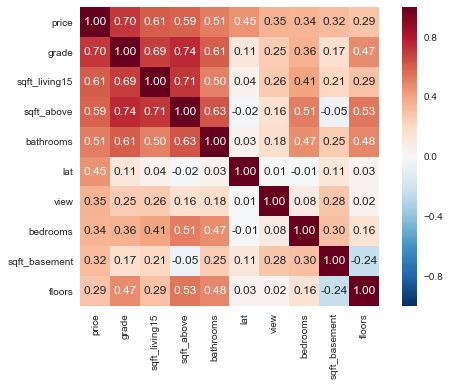

In [16]:
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

## Baseline algorithm test

There are a few regression algorithms I can use. I prefer to line the usable regression algorithms up and run them using a standard set of data. I check the negative mean square error of each run. The given data set is broken down into training set and testing set. The test set is 20% of the provided data set.

In [17]:
Y = data['price'].values
X = data.drop('price', axis = 1).values
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=42)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

The differing scales of the raw data may impact these algorithms. Part of a requirement for a standardised data set is to have each attribute have a mean value of zero and a standard deviation of 1. I implement standardisation using pipelines. I then use cross-validation to validate performance of algorithms in totality.

In [19]:
import time 

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
# evaluate each model in turn

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=21)
    start = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

LR: -0.063909 (0.002537) (run time: 0.081600)
LASSO: -0.268157 (0.008634) (run time: 0.042827)
EN: -0.227685 (0.008465) (run time: 0.051492)
KNN: -0.055005 (0.001804) (run time: 0.599514)
CART: -0.066659 (0.003437) (run time: 1.362888)
GBM: -0.035104 (0.001033) (run time: 8.643315)


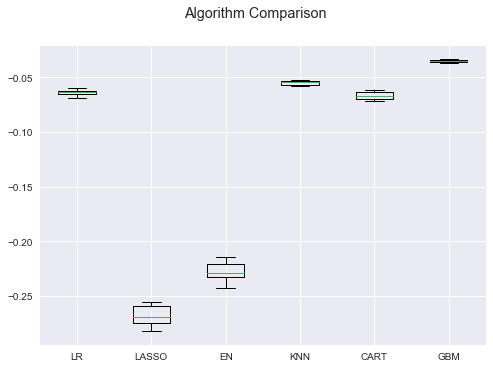

In [20]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the output above, it looks like the Gradient Boosting Regressor operforms the best using a scaled version of the data. From this point onward, I will build the regression algorithm using the Gradient Boosting Regressor. The GBM will be tested with a few n_estimators using the GridSearchCV function.

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(n_estimators=np.array([50,100,200,300,400, 500]))
model = GradientBoostingRegressor(random_state=21)
kfold = KFold(n_splits=10, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
start = time.time()
grid_result = grid.fit(X_train, Y_train)
end = time.time()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s (run time :%f)" % (grid_result.best_score_, grid_result.best_params_, end-start))

-0.041171 (0.001296) with: {'n_estimators': 50}
-0.035105 (0.001031) with: {'n_estimators': 100}
-0.031480 (0.000991) with: {'n_estimators': 200}
-0.030244 (0.001035) with: {'n_estimators': 300}
-0.029678 (0.001093) with: {'n_estimators': 400}
-0.029307 (0.001097) with: {'n_estimators': 500}
Best: -0.029307 using {'n_estimators': 500} (run time :142.283431)


The best n_estimator configuration is 400 with the negative mean square error closest to 0. 

## Finalise and validate model 

There's a need to standardise the training and test data before putting them through the GBR model. 

In [22]:
from sklearn.metrics import mean_squared_error

model = GradientBoostingRegressor(random_state=21, n_estimators=400)
model.fit(X_train, Y_train)

# transform the validation dataset
predictions = model.predict(X_test)
print (mean_squared_error(Y_test, predictions))

0.0296133301624


From the mean square error of 0.0296 between the prediction outputs vs the test data, the GBR performed pretty well. Important to note that the mean_square_error is calculated using the scaled data. It does not represent the error between the actual house prices and predicted prices. To better appreciate the outcome of the predictions, I look at the raw predicted values and the corresponding test data.

In [23]:
compare = pd.DataFrame({'Prediction': predictions, 'Test Data' : Y_test})
compare.head(10)

,Prediction,Test Data
0,12.90,12.81
1,13.63,13.67
2,13.93,13.85
3,14.60,14.21
4,13.45,13.47
5,12.43,12.26
6,13.51,13.58
7,13.35,13.43
8,12.97,12.86
9,13.26,13.31


From the data frame output above, the difference between the predicted value and test data is pretty small. Take note that the data is scaled and log normalised. So, we have to inverse transform these data to see the actual values. To do that, I apply the inverse_transform and exp function to the "Prediction" column

In [24]:
actual_y_test = np.exp(Y_test)
actual_predicted = np.exp(predictions)
diff = abs(actual_y_test - actual_predicted)

compare_actual = pd.DataFrame({'Test Data': actual_y_test, 'Predicted Price' : actual_predicted, 'Difference' : diff})
compare_actual = compare_actual.astype(int)
compare_actual.head(10)

,Difference,Predicted Price,Test Data
0,34032,399032,365000
1,35942,829057,865000
2,79569,1117569,1038000
3,695813,2185813,1490000
4,14102,696897,710999
5,38324,249324,211000
6,53524,736475,790000
7,54744,625255,680000
8,46737,431237,384499
9,29354,575645,604999


## Feature Importance

Let's take a look what are the important features GBR used to build the model.

In [25]:
train = data.drop('price', axis = 1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
priority = pd.DataFrame({'Attribute Label': train.columns, 'Feature Importances': model.feature_importances_})
priority = priority.sort_values('Feature Importances', ascending=False)

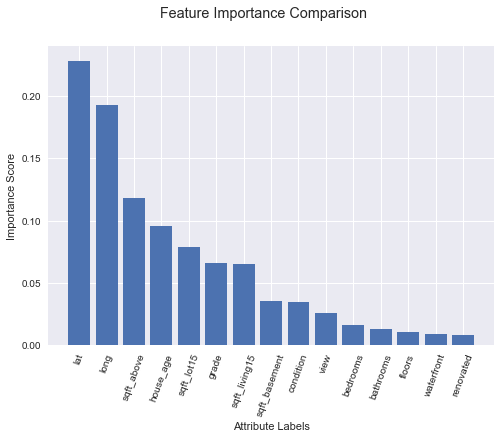

In [26]:
fig = plt.figure()
fig.suptitle('Feature Importance Comparison')
ax = fig.add_subplot(111)
plt.bar(range(len(priority)), priority['Feature Importances'])
ax.set_xticks(np.arange(len(priority['Attribute Label'])))
ax.set_xticklabels(priority['Attribute Label'], rotation=70)
plt.ylabel('Importance Score')
plt.xlabel('Attribute Labels')
plt.show()

## Other explorations

In [51]:
data = pd.read_csv('kc_house_data.csv')

data['date'] = pd.to_datetime(data['date'])
data = data.set_index('id')
data.price = data.price.astype(int)
data.bathrooms = data.bathrooms.astype(int)
data.floors = data.floors.astype(int)
data["house_age"] = data["date"].dt.year - data['yr_built']

From the output below, it looks like location (represented by lat/long), living space (sqft_above), age of house (house_age) and grade are the top influencers of the regression model. 

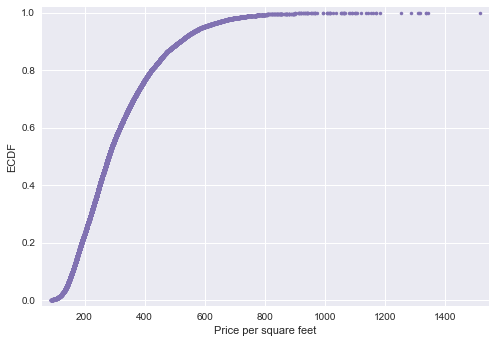

In [52]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

data['price per sq ft'] = data['price']/data['sqft_above']
x_vers, y_vers = ecdf(data['price per sq ft'])

_ = plt.plot(x_vers, y_vers, marker = '.', linestyle = 'none')
plt.margins(0.02)
_ = plt.xlabel('Price per square feet')
_ = plt.ylabel('ECDF')

plt.show()

In [82]:
top_psf = data[data['price per sq ft'] > 420]

In [76]:
lat1 = top_psf['lat'].min()
long1 = top_psf[top_psf['lat'] == lat1]['long']
print(lat1, long1.to_string(index=False))

47.2082 id
-121.995


In [77]:
lat2 = top_psf['lat'].max()
long2 = top_psf[top_psf['lat'] == lat2]['long']
print(lat2, long2.to_string(index=False))

47.7772 id
-122.357
